In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
from jax import lax
from jax import numpy as jnp
from jax import vmap, jit, grad, jacrev, jacfwd
from jax import random
from jaxopt.linear_solve import solve_gmres as solve
import random
import matplotlib.pyplot as plt
import time
from jax import tree_map
import jax
from queue import Queue
import copy
from scipy.sparse.linalg import gmres
from FMM_Treebuilder import treebuilder, domainbuilder, approx_tree_eval

cond = lax.cond
from multiprocessing import Pool


def sub(a, b):
    return a-b #(a.real-b.real, a.imag-b.imag)

def det(a, b):
    return a.real*b.imag - a.imag*b.real

def norm2(a):
    return a.real**2 + a.imag**2


def kern_bdry(r, s, t, tol=0.):
    """Kärnan i integralen för att beräkna A(r, h).
    Då s -> t får vi ett gränsvärde: det()
    """
    pos = abs(s-t) <= tol
    kern_nolim_ = lambda s: kern_nolim(r, s, t)
    kern_lim_ = lambda s: kern_lim(r, s)

    return cond(pos, kern_lim_, kern_nolim_, s) #pos = True => kern_lim pga nära randen

def grad_cplx(r):
    def cplxToReal(s):

        rs = r(s)
        return (jnp.real(rs), jnp.imag(rs))
    
    def grad_calc(s):
        #print(r(s))
        diff = jacfwd(cplxToReal)(s)
        #print(type(s))
        if s.ndim > 0:
            return jnp.sum(diff[0]+diff[1]*1j, axis=1)#diff[0] + diff[1]*1j
        else:
            return diff[0] + diff[1]*1j
    return grad_calc


def kern_cplx(r, s, x):
    z_i = r(s)     #Integrera över
    z_j = r(x)  #Evalpunkt
    kern_nolim_ = lambda s: kern_nolim(r, s, x) #kern_cplx_eval(r, s, x)
    kern_lim_ = lambda s: kern_lim(r, s)
    #print(jnp.min(s-x) < 0.01)
    return lax.cond(s-x < 0.00001,  kern_lim_, kern_nolim_, s)


def kern_cplx_eval(r, s, x):
    z_i = r(s)     #Integrera över
    z_j = r(x)  #Evalpunkt
    ##  print("Singularitet -------------\n-------------------------------")
    normal = grad_cplx(r)(s)*-1j/norm2(grad_cplx(r)(s))**0.5
    return (normal/(2*jnp.pi*(z_i - z_j))).real

def kern(r, s, x):  #Vanliga greens
    delta_r = sub(r(s), x)
    return det(delta_r, grad_cplx(r)(s)) / norm2(delta_r) / (2*jnp.pi)

def kern_nolim(r, s, t):    #Om vi befinner oss på randen men ej i punkten s = t
    return kern(r, s, r(t))

def kern_lim(r, s):
    dr = grad_cplx(r)(s) #jacrev(r)(s)
    ddr = grad_cplx(grad_cplx(r))(s)
    return -det(ddr, dr) / (2*norm2(dr)) /(2*jnp.pi) #minustecken fixar felet

def integration(f, mu, x, deltax):   #Trapetsregeln x går från 0 till 2 pi för cirkel
    """Integrera med trapetsregeln"""
    if len(x) > 1:
        return jnp.sum(vmap(f)(x) * deltax * mu)
    else:
        return jnp.sum(f(x) * deltax * mu)



def boundary_integral(r, t, **kwargs): #Vi befinner oss i s, integrerar över t
    """Evaluera integralen över randen"""
    integrand = lambda s: kern_bdry(r, s, t) #kern_cplx(r, s, t) #kern_bdry(r, s, t)
    eval = integration(integrand, **kwargs)
    return eval

def integral_operator(r, t, **kwargs):  #t = t(t1,t2) är evalueringspunkten
    integrand = lambda s: kern(r, s, t)
    eval = integration(integrand, **kwargs)
    return eval

def findmu(r, t_data, deltax, mu):
    sum_allmu = lambda t: boundary_integral(r, t, mu=mu, x=t_data, deltax=deltax)
    if len(t_data) > 1:
        return vmap(sum_allmu)(t_data) - 0.5*mu #*jnp.ones(t_data.size)
    else:
        return sum_allmu(t_data) - 0.5*mu


def trapezoid_initial(N):
    """Returnerar deltax och integraldomänen"""
    deltax = (2*jnp.pi/float(N)*jnp.ones(N))
    int_domain = (jnp.linspace(0, 2 * jnp.pi, N+1)[:-1])
    return {"int_domain": int_domain, "deltax": deltax}


def mask(r, int_domain, deltax, tol):
    #domainbool = lambda z: integral_operator(r, z, mu=1, x=int_domain, deltax=deltax) > tol
    domainbool = lambda z: norm2(r(z)) < 247 #jnp.sqrt(z*jnp.conj(z)) < 0.97
    return domainbool




#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------




@jit
def Delta_xi(points, center):
    delta_xi_k = lambda point: point-center
    return delta_xi_k(points)
@jit
def C_tilde(c_k_vec, delta_xi, n):
    arg = lambda c_k, del_xi_k: jnp.multiply(c_k,del_xi_k**n)
    return vmap(arg)(c_k_vec, delta_xi)
@jit
def C_tilde_vec(delta_xi, c_k_vec):
    N = 8
    n = jnp.linspace(0,N,N+1)
    #print(n)
    c_tilde_n = lambda n_placeholder: C_tilde(c_k_vec, delta_xi, n_placeholder)
    return vmap(c_tilde_n)(n).sum(axis=1)

@jit
def eval_exact(mu_tilde, x, x_eval, tol=1e-5):
    return jnp.sum(jnp.where(jnp.abs(x-x_eval)<tol, 0, mu_tilde / (x_eval - x) / (2*jnp.pi)))

def fmm(mu_tilde, root, xvec, pointcriteria, tol):
    q = Queue()
    potvec = []
    
    num_exacteval = 0
    num_approxeval = 0
    tot = 0

    for i in range(0, len(xvec)):
        exact_eval_vec = []
        #num_approxeval = 0
        approx = 0

        [q.put(child) for child in root.children()]
        while q.qsize() != 0:
            rectangle = q.get()
            rho = norm2(rectangle.sidelength/jnp.sqrt(2) / (xvec[i] - rectangle.center))**0.5

            if rho < tol:
                approx += rectangle.approx[i]
                num_approxeval += 1
                
            elif rectangle.points_box > pointcriteria:
                [q.put(child) for child in rectangle.children()]
            else:
                exact_eval_vec.append(rectangle.points_index)
                num_exacteval += rectangle.domain.size


        exact_idx_i = jnp.array([pindex for pindexlist in exact_eval_vec for pindex in pindexlist[0]]) #består av listor leder till dimensionsfel
        exact_pot_i = eval_exact(mu_tilde[exact_idx_i], xvec[exact_idx_i], xvec[i])
        

        potvec.append(exact_pot_i + approx) 

    print("Antal exakta evalueringar: " + str(num_exacteval))
    print("Antal approx evalueringar: " + str(num_approxeval))

    #print(potvec)
    return jnp.asarray(potvec)


def matvec(mu, root, xvec, pointcriteria, rand, tol, int_domain):
    normal = -1j*jit(vmap(grad_cplx(rand)))(int_domain)
    weights = jnp.ones(int_domain.size) * 2*jnp.pi / int_domain.size
    mu_tilde = mu * normal * weights
    
    #newroot = approx_tree_eval(root.getPytree(), rand, mu_tilde)
    approx_tree_eval(root, rand, mu_tilde)

    result = fmm(mu_tilde, root, xvec, pointcriteria, tol).real
    
    result = result - 0.5 * mu - vmap(kern_lim, (None, 0))(rand, int_domain) * mu * weights
    return result


@jit
def potential_med_c(deltaxi, mu_normal, xi):
    N = 8   #Gör stor skillnad på lösningen
    n = jnp.linspace(0,N,N+1)
    cvec = C_tilde_vec(deltaxi, mu_normal)
    return jnp.sum(cvec / (xi**(n+1))) / (2*jnp.pi)

@jit
def pot_c_helper(deltaxi, mu_normal, n, xi):
    c_tilde_eval = C_tilde_vec(deltaxi, mu_normal)
    pot = lambda ctilde: ctilde*1/(xi**(n+1))
    #print("ctilde vec är: " + str(c_tilde_eval))
    #print("g(x) är: " + str(vmap(pot)(c_tilde_eval)))
    #print("xi är: " + str(xi))
    return vmap(pot)(c_tilde_eval)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Kolla c

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


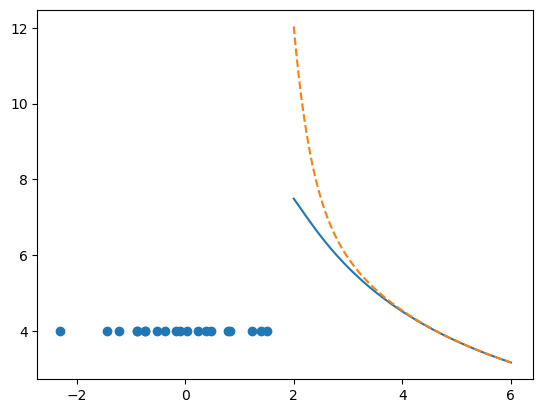

In [2]:
N = 20
deltaxi = np.random.normal(0, 1, N) + 1j * np.random.normal(0, 1, N)
xi_list = np.linspace(2, 6, 100)
v = np.ones(N)
ctilde = C_tilde_vec(deltaxi, v)
nlist = np.linspace(0, 8, 9)

pots = []
pots_fmm = []

for xi in xi_list:
    pots.append(np.sum(v / (xi - deltaxi)).real)
    pots_fmm.append(np.sum(ctilde / xi ** (nlist+1)).real)

plt.scatter(deltaxi.real, 4*np.ones_like(deltaxi.real))
plt.plot(xi_list, pots)
plt.plot(xi_list, pots_fmm, '--')

#pot_exakt = 

Kolla matvec

In [ ]:
r = lambda t: jnp.cos(t) + 1j*jnp.sin(t) #jnp.exp(1j*t)
N = 200
t = jnp.linspace(0, 2*jnp.pi, N+1)[:-1]# + 0.001134
g = lambda t: jnp.sin(3*t) #1/(r(t) - 2j).imag

#domain = vmap(r)(t)
#domainsize = 2.2
domain, domainsize = domainbuilder(N, 1)
pointcriteria = 3

tol = 1/4

tree, num_rect = treebuilder(domain, domainsize, pointcriteria, N, tol)
print("Antal rektanglar: " + str(num_rect))
Amu_ = lambda mu: findmu(r, t, 2*jnp.pi/N, mu)
Amu = Amu_(g(t))#solve(Amu_, vmap(g)(t), tol=1e-6)
print("klar randint")
Amu_f = lambda mu: matvec_parallel(Pool(30), mu, tree, domain, pointcriteria, r, tol, t)
#Amu_f = lambda mu: matvec(mu, tree, domain, pointcriteria, r, tol, t)
Amu_fmm = Amu_f(g(t))
#Amu_fmm = solve(Amu_f, g(t), tol=1e-6)
plt.figure()
plt.plot(t, Amu)
plt.plot(t, Amu_fmm, '--')

Tidskomplexitet

Tid att beräkna trädets deltaxi och xi: 0.0405879020690918
Tid att bygga trädet: 0.17205309867858887
Antal rektanglar: 16
Antal exakta evalueringar: 5988
Antal approx evalueringar: 496


/tmp/ipykernel_298618/3230973982.py:34: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  Amu_fmm = gmres(A, np.array(mu), np.zeros_like(mu), tol=1e-6)


Antal exakta evalueringar: 5988
Antal approx evalueringar: 496
Antal exakta evalueringar: 5988
Antal approx evalueringar: 496
Tid att beräkna trädets deltaxi och xi: 0.028688669204711914
Tid att bygga trädet: 0.13312745094299316
Antal rektanglar: 16
Antal exakta evalueringar: 23752
Antal approx evalueringar: 996
Antal exakta evalueringar: 23752
Antal approx evalueringar: 996
Antal exakta evalueringar: 23752
Antal approx evalueringar: 996
Tid att beräkna trädets deltaxi och xi: 0.1131746768951416
Tid att bygga trädet: 0.4738442897796631
Antal rektanglar: 56
Antal exakta evalueringar: 35544
Antal approx evalueringar: 6324
Antal exakta evalueringar: 35544
Antal approx evalueringar: 6324
Antal exakta evalueringar: 35544
Antal approx evalueringar: 6324
Antal exakta evalueringar: 35544
Antal approx evalueringar: 6324
fmm med 100punkter är: 4.499061394234649 gånger långsammare
fmm med 200punkter är: 10.375367550845256 gånger långsammare
fmm med 400punkter är: 34.51537039387984 gånger långsamm

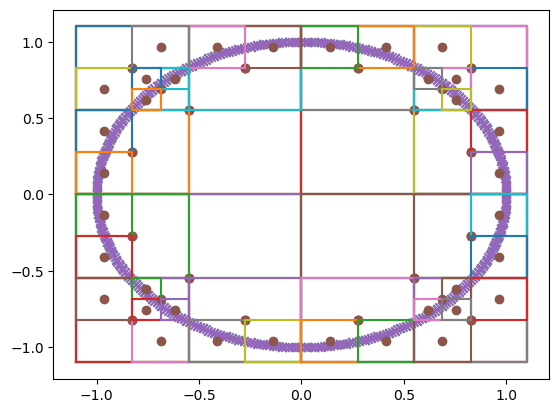

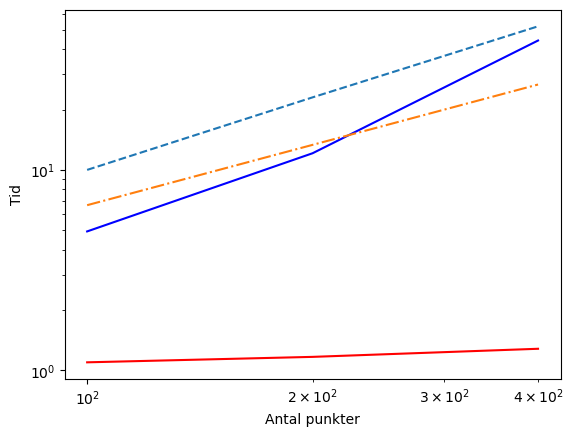

In [15]:
from scipy.sparse.linalg import LinearOperator

r = lambda t: jnp.exp(1j*t)
#N = 800
#t = jnp.linspace(0, 2*jnp.pi, N+1)[:-1]# + 0.001134

#domain = vmap(r)(t)
domainsize = 2.2
pointcriteria = 20
pointsvec = np.array([100, 200, 400])#, 800, 1600, 2000])
timevec = []
timevec2 = []
for num_points in pointsvec:
    t = jnp.linspace(0, 2*jnp.pi, num_points+1)[:-1]# + 0.001134
    domain = vmap(r)(t)

    start = time.time()
    #num_points = N
    tol = 1/4

    treestart = time.time()
    tree, num_rect = treebuilder(domain, domainsize, pointcriteria, num_points, tol)
    treeend = time.time()
    print("Tid att bygga trädet: " + str(treeend - treestart))
    print("Antal rektanglar: " + str(num_rect))
    mu = jnp.sin(3*t)
    
    # Inte FMM
    #Amu = findmu(r, t, 2*jnp.pi/N, mu)
    
    # FMM
    matvec_wrap = lambda mu: np.array(matvec(mu, tree, domain, pointcriteria, r, tol, t))
    A = LinearOperator((num_points, num_points), matvec=matvec_wrap)
    Amu_fmm = gmres(A, np.array(mu), np.zeros_like(mu), tol=1e-6)
    
    #Amu_fmm = matvec(mu, tree, domain, pointcriteria, r, tol, t)
    
    end = time.time()
    timevec.append(end-start)

for num_points in pointsvec:
    t = jnp.linspace(0, 2*jnp.pi, num_points+1)[:-1]# + 0.001134
    mu = jnp.sin(3*t)

    start = time.time()
    #Amu = findmu(r, t, 2*jnp.pi/num_points, mu)
    Amu = solve(lambda mu: findmu(r, t, 2*jnp.pi/N, mu), mu, tol=1e-6)
    
    end = time.time()
    timevec2.append(end - start)

timevec = np.asarray(timevec)
timevec2 = np.asarray(timevec2)
plt.figure()
plt.plot(pointsvec, timevec, 'b')
plt.plot(pointsvec, pointsvec*np.log10(pointsvec)/20, '--')
plt.plot(pointsvec, pointsvec/15, '-.')
plt.plot(pointsvec, timevec2, 'r')
plt.yscale("log")
plt.xscale("log")
plt.ylabel('Tid')
plt.xlabel('Antal punkter')
print("fmm med " + str(pointsvec[0]) + "punkter är: " + str(timevec[0]/timevec2[0]) + " gånger långsammare")
print("fmm med " + str(pointsvec[1]) + "punkter är: " + str(timevec[1]/timevec2[1]) + " gånger långsammare")
print("fmm med " + str(pointsvec[2]) + "punkter är: " + str(timevec[2]/timevec2[2]) + " gånger långsammare")



#plt.figure()
#plt.plot(t, Amu)
#plt.plot(t, Amu_fmm, '--')

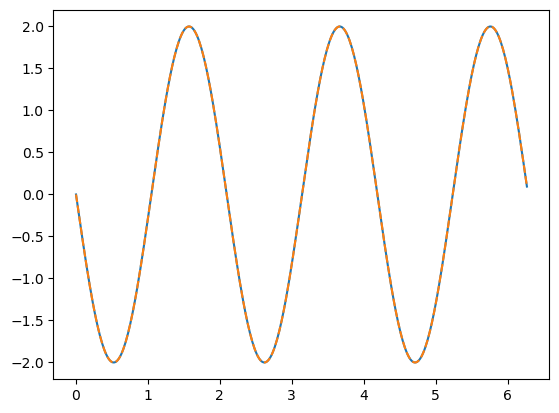

In [16]:
plt.figure()
plt.plot(t, Amu)
plt.plot(t, Amu_fmm[0], '--')

Tidskomplex bara matvec/randint

Klar 100 punkter
Klar 200 punkter
Klar 400 punkter
Klar 800 punkter
Klar 1200 punkter
Klar 1600 punkter
Klar 2000 punkter
Klar 5000 punkter
Klar 10000 punkter
Klar 20000 punkter
[    10000     40000    160000    640000   1440000   2560000   4000000
  25000000 100000000 400000000]
[  100   200   400   800  1200  1600  2000  5000 10000 20000]


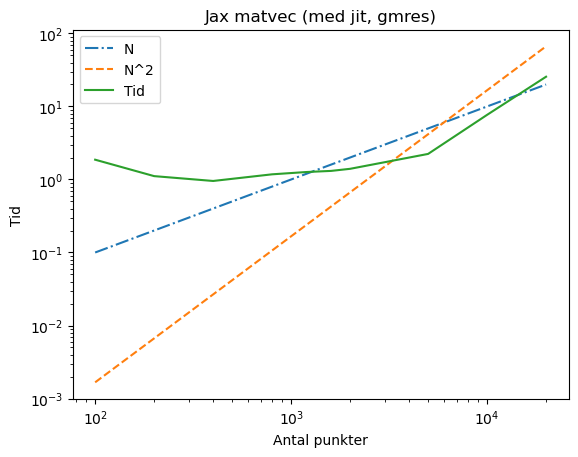

In [ ]:
r = lambda t: jnp.exp(1j*t)
domainsize = 2.2
pointcriteria = 20
pointsvec = np.array([100, 200, 400, 800, 1200, 1600, 2000, 5000, 10000, 20000])  #, 30000, 40000, 50000, 55000])
timevec2 = []

for num_points in pointsvec:
    t = jnp.linspace(0, 2*jnp.pi, num_points+1)[:-1]# + 0.001134
    mu = jnp.sin(3*t)
    g = lambda t: jnp.sin(3*t)
    start = time.time()
    Amu_ = jit(lambda mu_: findmu(r, t, 2*jnp.pi/num_points, mu_))
    Amu = solve(Amu_, vmap(g)(t), tol=1e-6)     #Amu_(mu) #vmap(Amu_)(mu)
    end = time.time()
    timevec2.append(end - start)
    print("Klar " + str(num_points) + " punkter")

#plt.figure()
#plt.plot(pointsvec, pointsvec*np.log10(pointsvec)/300, '--')
plt.plot(pointsvec, pointsvec/1e3, '-.', label='N')
plt.plot(pointsvec, np.array(pointsvec, dtype='int64')**2/6e6, '--', label='N^2')
print(np.array(pointsvec, dtype='int64')**2)
print(pointsvec)
plt.plot(pointsvec, timevec2, label='Tid')
plt.yscale("log")
plt.xscale("log")
plt.ylabel('Tid')
plt.xlabel('Antal punkter')
plt.title("Jax matvec (med jit, gmres)")
plt.legend()


Egenvärden hos A

Tid att beräkna trädets deltaxi och xi: 0.8358416557312012
ej positiv definit matris
[49.500004  +0.0000000e+00j -0.4999985 +0.0000000e+00j
 -0.49999863+0.0000000e+00j -0.50000083+6.7055220e-07j
 -0.50000083-6.7055220e-07j -0.49999946+7.6794987e-07j
 -0.49999946-7.6794987e-07j -0.5000005 +1.2644055e-07j
 -0.5000005 -1.2644055e-07j -0.50000066+0.0000000e+00j
 -0.5000006 +0.0000000e+00j -0.5000012 +0.0000000e+00j
 -0.49999964+2.3560804e-07j -0.49999964-2.3560804e-07j
 -0.50000095+0.0000000e+00j -0.49999988+3.5262585e-07j
 -0.49999988-3.5262585e-07j -0.5000001 +1.3898878e-07j
 -0.5000001 -1.3898878e-07j -0.5       +3.3119485e-07j
 -0.5       -3.3119485e-07j -0.49999982+0.0000000e+00j
 -0.49999923+0.0000000e+00j -0.50000036+2.9715244e-07j
 -0.50000036-2.9715244e-07j -0.4999997 +3.4240261e-07j
 -0.4999997 -3.4240261e-07j -0.5000003 +0.0000000e+00j
 -0.5000006 +1.4385411e-07j -0.5000006 -1.4385411e-07j
 -0.5000001 +0.0000000e+00j -0.49999896+0.0000000e+00j
 -0.4999992 +0.0000000e+00j -0.4999

Text(0.5, 1.0, 'Egenvärden för A')

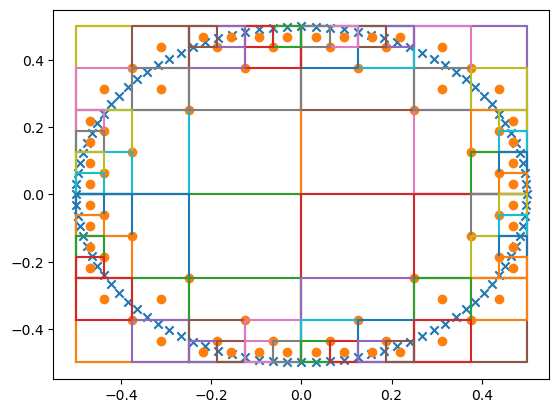

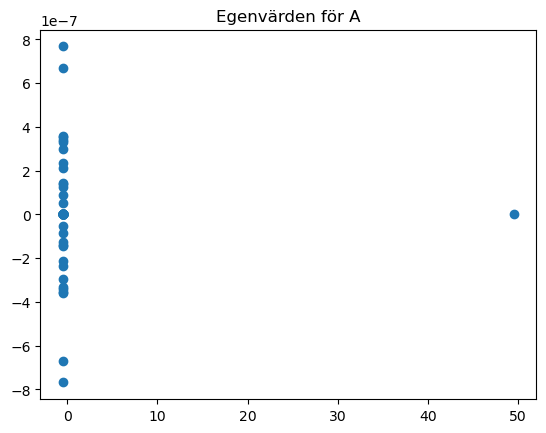

In [ ]:
r = lambda t: jnp.cos(t) + 1j*jnp.sin(t) #jnp.exp(1j*t)
N = 100
t = jnp.linspace(0, 2*jnp.pi, N+1)[:-1]# + 0.001134
g = lambda t: jnp.sin(3*t) #1/(r(t) - 2j).imag

#domain = vmap(r)(t)
#domainsize = 2.2
domain, domainsize = domainbuilder(N, 1)
pointcriteria = 3

tol = 1/4

tree, num_rect = treebuilder(domain, domainsize, pointcriteria, N, tol)

mtrx = findmu(r, t, 2*jnp.pi/N, jnp.eye(N))

plt.figure()

try:
    np.linalg.cholesky(mtrx)
    print("Positiv definit matris")
except:
    print("ej positiv definit matris")
eig = jnp.linalg.eig(mtrx)
print(eig[0])
plotlist = []
for i in range(0,len(eig[0])):
    if not np.sqrt(eig[0][i].real**2 + eig[0][i].imag**2) > 2:
        plotlist.append(eig[0][i])
#plt.scatter(np.real(plotlist), np.imag(plotlist))
plt.scatter(eig[0].real, eig[0].imag)
#plt.grid()
#ax = plt.gca()
#ax.set_xlim([-0.7, 0.2])
#ax.set_ylim([-1e-3, 1e-3])
#left,right = ax.get_xlim()
#low,high = ax.get_ylim()
#plt.plot([left, right],[0,0] , 'k', linewidth=0.7)
#plt.plot([0,0], [low, high], 'k', lw=0.7)
plt.title("Egenvärden för A")
#plt.figure()

Trädbygge

Tid att beräkna trädets deltaxi och xi: 9.634793281555176
Tid att bygga trädet: 18.09284496307373
Antal rektanglar: 948


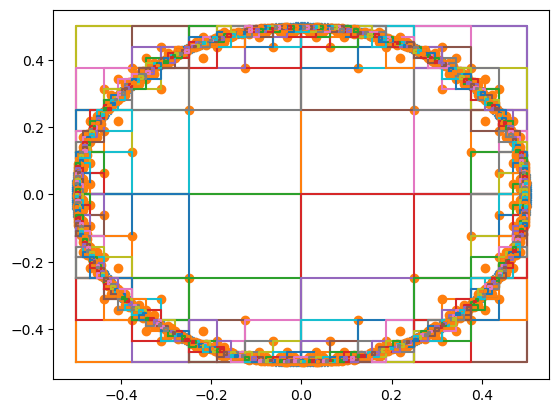

In [ ]:


pointcriteria = 1
interval = 1
N = 500
domain, domainsize = domainbuilder(N, interval)
num_points = len(domain)
tol = 1/4


treestart = time.time()
tree, num_rect = treebuilder(domain, domainsize, pointcriteria, len(domain), tol)
treeend = time.time()
print("Tid att bygga trädet: " + str(treeend - treestart))
print("Antal rektanglar: " + str(num_rect))